In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

print(os.listdir("dataset"))

['HAM10000_metadata.csv', 'HAM10000_images_part_1', 'hmnist_8_8_L.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_2', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_L.csv']


In [2]:
data_dir = 'dataset'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [4]:
norm_mean, norm_std = compute_img_mean_std(all_image_path)

100%|████████████████████████████████████████████████████████████████████████████| 10015/10015 [01:15<00:00, 133.17it/s]


(224, 224, 3, 10015)
normMean = [0.76303905, 0.54564434, 0.5700453]
normStd = [0.14092831, 0.15261248, 0.16997118]


In [5]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,dataset/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [6]:
# Count the number of females and males in the dataset
gender_counts = df_original['sex'].value_counts()
print(gender_counts)


male       5406
female     4552
unknown      57
Name: sex, dtype: int64


In [7]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [8]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,dataset/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [9]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [10]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [11]:
y = df_undup['cell_type_idx']
df_train, df_val = train_test_split(df_undup, test_size=0.5, random_state=101, stratify=y)
df_train.shape, df_val.shape

((2757, 11), (2757, 11))

In [12]:
# Calculate the number of males and females in the train dataset
train_male_count = len(df_train[df_train['sex'] == 'male'])
train_female_count = len(df_train[df_train['sex'] == 'female'])

# Calculate the number of males and females in the validation dataset
val_male_count = len(df_val[df_val['sex'] == 'male'])
val_female_count = len(df_val[df_val['sex'] == 'female'])

print("Training dataset:")
print(f"Males: {train_male_count}")
print(f"Females: {train_female_count}")

print("\nValidation dataset:")
print(f"Males: {val_male_count}")
print(f"Females: {val_female_count}")


Training dataset:
Males: 1435
Females: 1300

Validation dataset:
Males: 1472
Females: 1262


In [13]:
df_val['cell_type_idx'].value_counts()

4    2208
2     220
6     115
1      88
0      75
5      32
3      19
Name: cell_type_idx, dtype: int64

In [14]:
df_train['cell_type_idx'].value_counts()

4    2207
2     220
6     115
1      87
0      76
5      32
3      20
Name: cell_type_idx, dtype: int64

In [15]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(f"Training dataset: {len(df_train)}")
print(f"Validation dataset: { len(df_val)}")

Training dataset: 7258
Validation dataset: 2757


In [16]:
# Calculate the number of males and females in the train dataset
train_male_count = len(df_train[df_train['sex'] == 'male'])
train_female_count = len(df_train[df_train['sex'] == 'female'])

# Calculate the number of males and females in the validation dataset
val_male_count = len(df_val[df_val['sex'] == 'male'])
val_female_count = len(df_val[df_val['sex'] == 'female'])

print("Training dataset:")
print(f"Males: {train_male_count}")
print(f"Females: {train_female_count}")

print("\nValidation dataset:")
print(f"Males: {val_male_count}")
print(f"Females: {val_female_count}")


Training dataset:
Males: 3934
Females: 3290

Validation dataset:
Males: 1472
Females: 1262


In [17]:
df_train['cell_type_idx'].value_counts()

4    4497
6     998
2     879
1     426
0     252
5     110
3      96
Name: cell_type_idx, dtype: int64

In [18]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  2208
Benign keratosis-like lesions      220
dermatofibroma                     115
Basal cell carcinoma                88
Actinic keratoses                   75
Vascular lesions                    32
Dermatofibroma                      19
Name: cell_type, dtype: int64

In [19]:
df_train['sex'].value_counts()

male       3934
female     3290
unknown      34
Name: sex, dtype: int64

In [20]:
df_train['age'].value_counts()

45.0    835
50.0    786
55.0    686
40.0    666
70.0    605
60.0    572
65.0    567
35.0    539
75.0    477
30.0    363
80.0    312
85.0    254
25.0    194
20.0    146
15.0     74
5.0      74
0.0      38
10.0     37
Name: age, dtype: int64

In [21]:
df_train['localization'].value_counts()

back               1691
lower extremity    1461
upper extremity     879
trunk               803
abdomen             674
face                630
chest               350
foot                240
unknown             141
neck                132
scalp               109
hand                 66
ear                  48
genital              28
acral                 6
Name: localization, dtype: int64

## Bias Mitigation: Data Augmentation (Oversampling training data)

In [22]:
# # Copy fewer class to balance the number of 7 classes
data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

/tmp/ipykernel_656135/2085359477.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)


dermatofibroma                    4990
Dermatofibroma                    4800
Melanocytic nevi                  4497
Vascular lesions                  4400
Benign keratosis-like lesions     4395
Basal cell carcinoma              4260
Actinic keratoses                 3780
Name: cell_type, dtype: int64

In [23]:
# split validation into val and test
df_val, df_test = train_test_split(df_val, test_size=0.7)  
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()


In [24]:
print(f" Training dataset size: {len(df_train)}")
print(f" Testing dataset size: {len(df_test)}")
print(f" Validation dataset size: {len(df_val)}")

 Training dataset size: 31122
 Testing dataset size: 1930
 Validation dataset size: 827


In [25]:
# df_train['age'].value_counts()

In [26]:
# # Filter the test dataset based on age groups
# below_20_df = df_test[df_test['age'] <= 20].reset_index(drop=True)
# between_20_40_df = df_test[(df_test['age'] > 20) & (df_test['age'] <= 40)].reset_index(drop=True)
# between_40_60_df = df_test[(df_test['age'] > 40) & (df_test['age'] <= 60)].reset_index(drop=True)
# above_60_df = df_test[df_test['age'] > 60].reset_index(drop=True)


In [27]:
# # Assuming your DataFrame is called 'df' and has a column 'age' with the age of each sample
# age_bins = [0, 20, 40, 60, np.inf]
# age_group_labels = [0, 1, 2, 3]
# df_train['age_group'] = pd.cut(df_train['age'], bins=age_bins, labels=age_group_labels)
# df_val['age_group'] = pd.cut(df_train['age'], bins=age_bins, labels=age_group_labels)
# df_test['age_group'] = pd.cut(df_train['age'], bins=age_bins, labels=age_group_labels)

# df_train = df_train.dropna(subset=['age_group'])
# df_val = df_val.dropna(subset=['age_group'])
# df_test = df_test.dropna(subset=['age_group'])

# df_train = df_train.dropna(subset=['age_group']).reset_index(drop=True)
# df_val = df_val.dropna(subset=['age_group']).reset_index(drop=True)
# df_test = df_test.dropna(subset=['age_group']).reset_index(drop=True)




In [26]:
body_regions = {
    'Upper body': ['face', 'neck', 'scalp', 'ear', 'chest', 'upper extremity', 'hand'],
    'Mid body': ['trunk', 'back', 'abdomen'],
    'Lower body': ['lower extremity', 'foot', 'genital', 'acral']
}

localization_mapping = {area: region for region, areas in body_regions.items() for area in areas}


In [27]:
# add new column body region
df_test['body_region'] = df_test['localization'].replace(localization_mapping)
df_train['body_region'] = df_train['localization'].replace(localization_mapping)
df_val['body_region'] = df_val['localization'].replace(localization_mapping)



In [28]:
# test
upper_body_df = df_test[df_test['localization'].isin(body_regions['Upper body'])].reset_index(drop=True)
mid_body_df = df_test[df_test['localization'].isin(body_regions['Mid body'])].reset_index(drop=True)
lower_body_df = df_test[df_test['localization'].isin(body_regions['Lower body'])].reset_index(drop=True)

# train
upper_body_df_train = df_train[df_train['localization'].isin(body_regions['Upper body'])].reset_index(drop=True)
mid_body_df_train = df_train[df_train['localization'].isin(body_regions['Mid body'])].reset_index(drop=True)
lower_body_df_train = df_train[df_train['localization'].isin(body_regions['Lower body'])].reset_index(drop=True)


# val
upper_body_df_val = df_val[df_val['localization'].isin(body_regions['Upper body'])].reset_index(drop=True)
mid_body_df_val = df_val[df_val['localization'].isin(body_regions['Mid body'])].reset_index(drop=True)
lower_body_df_val = df_val[df_val['localization'].isin(body_regions['Lower body'])].reset_index(drop=True)



In [29]:
df_test['body_region'].value_counts()


Mid body      1012
Lower body     503
Upper body     346
unknown         69
Name: body_region, dtype: int64

In [30]:
df_train['body_region'].value_counts()


Upper body    12152
Mid body      10005
Lower body     8692
unknown         273
Name: body_region, dtype: int64

In [49]:
print(f" Training dataset size: {len(df_train)}")
print(f" Testing dataset size: {len(df_test)}")
print(f" Validation dataset size: {len(df_val)}")

 Training dataset size: 31122
 Testing dataset size: 1930
 Validation dataset size: 827


In [50]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [51]:
import torch.nn.functional as F

class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -grad_output

class AgeClassifier(nn.Module):
    def __init__(self, num_classes, num_age_groups):
        super(AgeClassifier, self).__init__()
        self.fc = nn.Linear(num_classes, num_age_groups)

    def forward(self, x):
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    


class LocalizationClassifier(nn.Module):
    def __init__(self, input_size, num_body_regions):
        super(LocalizationClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_body_regions)

    def forward(self, x):
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [52]:
#  let's modify the initialize_model function to add the age classifier:


from torchvision.models import resnet18, vgg16, densenet121, inception_v3, resnet50, resnet101
from torchvision.models.densenet import DenseNet121_Weights

def initialize_model(model_name, num_classes, num_body_regions, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    # modified only this
    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1 if use_pretrained else None)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

        localization_classifier = LocalizationClassifier(num_classes, num_body_regions)

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, localization_classifier, input_size



In [53]:
# Initialize the model for this run
model_name = 'densenet'
num_classes = 7
feature_extract = False

num_body_regions = 4  # Define the number of body regions
model_ft, localization_classifier, input_size = initialize_model(model_name, num_classes, num_body_regions, feature_extract, use_pretrained=True)
localization_classifier = LocalizationClassifier(num_classes, num_body_regions)


# Define the device:
device = torch.device('cuda:3')
# Put the model on the device:
model = model_ft.to(device)

localization_classifier = localization_classifier.to(device)



In [54]:
train_transform = transforms.Compose([transforms.Resize((224, 224)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# define the transformation of the val images.
test_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [55]:
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))
        localization_mapping = {'Upper body': 0, 'Mid body': 1, 'Lower body': 2, 'unknown': 3}

        localization = torch.tensor(localization_mapping[self.df['body_region'][index]])

        if self.transform:
            X = self.transform(X)

        return X, y, localization



In [56]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)


# transform for the validation set
validation_set = HAM10000(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)
# transform for the test  set (No jitter, rotations)
test_set = HAM10000(df_test, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

## Adversarial Training

In [57]:
# for classifier training


# For the classifier training
optimizer_localization = optim.SGD(localization_classifier.parameters(), lr=0.001, momentum=0.9)
criterion_localization = nn.CrossEntropyLoss().to(device)




# model training
# we use Adam optimizer, use weighted-cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)



In [58]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [59]:
def train(train_loader, model, localization_classifier, criterion, criterion_localization, optimizer, optimizer_localization, epoch):
    model.train()
    localization_classifier.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    localization_loss_meter = AverageMeter()
    localization_acc = AverageMeter()

    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels, localizations = data
        N = images.size(0)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        localizations = Variable(localizations).to(device)

        optimizer.zero_grad()
        optimizer_localization.zero_grad()

        # Compute the model output and the localization classifier output
        outputs = model(images)
        localization_outputs = localization_classifier(GradientReversalLayer.apply(outputs))

        # Compute the classification loss and the adversarial loss
        loss = criterion(outputs, labels)
        localization_loss = criterion_localization(localization_outputs, localizations)
        total_loss = loss + 0.4 * localization_loss   # alpha (adversarial loss)

        total_loss.backward()
        optimizer.step()
        optimizer_localization.step()

        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        
        localization_prediction = localization_outputs.max(1, keepdim=True)[1]
        localization_acc_value = localization_prediction.eq(localizations.view_as(localization_prediction)).sum().item()/N
        localization_acc.update(localization_acc_value)
        localization_loss_meter.update(localization_loss.item())

        curr_iter += 1
    
    print('[epoch %d], [train loss %.5f], [train acc %.5f], [localization loss %.5f], [localization acc %.5f]' % (
        epoch, train_loss.avg, train_acc.avg, localization_loss_meter.avg, localization_acc.avg))
    total_loss_train.append(train_loss.avg)
    total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg, localization_loss_meter.avg, localization_acc.avg



In [62]:

def validate(val_loader, model, localization_classifier, criterion, criterion_localization, optimizer, optimizer_localization, epoch):
    model.eval()
    localization_classifier.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    localization_loss_meter = AverageMeter()
    localization_acc = AverageMeter()

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels, localizations = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            localizations = Variable(localizations).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]
            localization_outputs = localization_classifier(GradientReversalLayer.apply(outputs))
            localization_prediction = localization_outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
            val_loss.update(criterion(outputs, labels).item())
            localization_loss_meter.update(criterion_localization(localization_outputs, localizations).item())
            localization_acc.update(localization_prediction.eq(localizations.view_as(localization_prediction)).sum().item()/N)

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f], [localization val loss %.5f], [localization val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg, localization_loss_meter.avg, localization_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg, localization_loss_meter.avg, localization_acc.avg


In [63]:

epoch_num = 25
best_val_acc = 0

total_loss_train, total_acc_train, total_localization_loss_train, total_localization_acc_train = [], [], [], []
total_loss_val, total_acc_val, total_localization_loss_val, total_localization_acc_val = [], [], [], []

for epoch in range(1, epoch_num + 1):
    # Train the model and the localization classifier
    loss_train, acc_train, localization_loss_train, localization_acc_train = train(train_loader, model, localization_classifier, criterion, criterion_localization, optimizer, optimizer_localization, epoch)
    
    # Validate the model and the localization classifier
    loss_val, acc_val, loss_val_localization, acc_val_localization = validate(val_loader, model, localization_classifier, criterion, criterion_localization, optimizer, optimizer_localization, epoch)
    
    total_loss_train.append(loss_train)
    total_acc_train.append(acc_train)
    total_localization_loss_train.append(localization_loss_train)
    total_localization_acc_train.append(localization_acc_train)
    
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    total_localization_loss_val.append(loss_val_localization)
    total_localization_acc_val.append(acc_val_localization)
    
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        torch.save(model.state_dict(), "2_adversarial_learning_skin_lesion.pt")
        torch.save(localization_classifier.state_dict(), "localization_classifier_skin_lesion.pt")
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')


[epoch 1], [train loss 0.68735], [train acc 0.74537], [localization loss 1.17940], [localization acc 0.46351]
------------------------------------------------------------
[epoch 1], [val loss 0.50011], [val acc 0.80658], [localization val loss 1.11633], [localization val acc 0.52204]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.50011], [val acc 0.80658]
*****************************************************
[epoch 2], [train loss 0.55294], [train acc 0.78981], [localization loss 1.16729], [localization acc 0.44139]
------------------------------------------------------------
[epoch 2], [val loss 0.41896], [val acc 0.86133], [localization val loss 1.15714], [localization val acc 0.49582]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.41896], [val acc 0.86133]
**********************

[epoch 23], [train loss 32338.64524], [train acc 0.19762], [localization loss 59326148.88695], [localization acc 0.33306]
------------------------------------------------------------
[epoch 23], [val loss 3846.90076], [val acc 0.05235], [localization val loss 142772912.00000], [localization val acc 0.18425]
------------------------------------------------------------
[epoch 24], [train loss 37116.32980], [train acc 0.19043], [localization loss 78422898.74358], [localization acc 0.32949]
------------------------------------------------------------
[epoch 24], [val loss 4782.61259], [val acc 0.04251], [localization val loss 81069303.23077], [localization val acc 0.52956]
------------------------------------------------------------
[epoch 25], [train loss 42231.85024], [train acc 0.18441], [localization loss 101765035.79959], [localization acc 0.33196]
------------------------------------------------------------
[epoch 25], [val loss 4702.85850], [val acc 0.05791], [localization val loss 

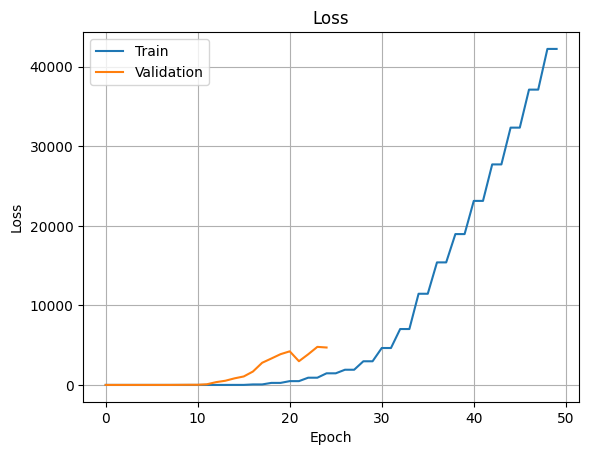

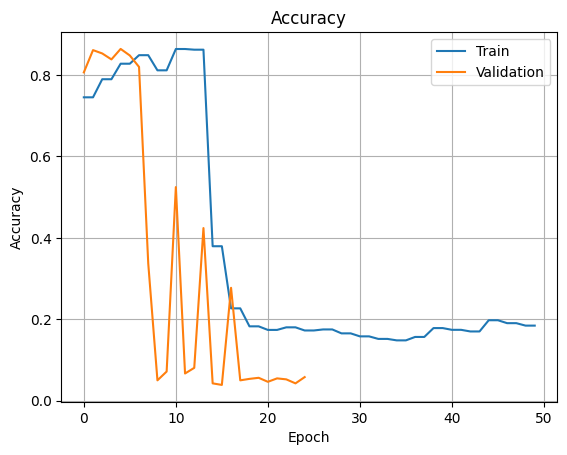

In [64]:


plt.plot(total_loss_train, label='Train')
plt.plot(total_loss_val, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the training and validation accuracy
plt.plot(total_acc_train, label='Train')
plt.plot(total_acc_val, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()



In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

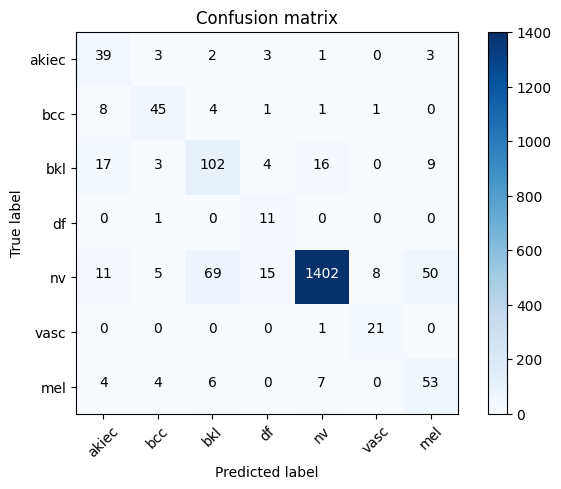

In [66]:
# Load saved state dict of trained model



state_dict = torch.load('2_adversarial_learning_skin_lesion.pt')
model.load_state_dict(state_dict)


model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels, _ = data  # add "_" to unpack the age_groups
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [67]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.49      0.76      0.60        51
         bcc       0.74      0.75      0.74        60
         bkl       0.56      0.68      0.61       151
          df       0.32      0.92      0.48        12
          nv       0.98      0.90      0.94      1560
        vasc       0.70      0.95      0.81        22
         mel       0.46      0.72      0.56        74

    accuracy                           0.87      1930
   macro avg       0.61      0.81      0.68      1930
weighted avg       0.90      0.87      0.88      1930



## Bias Investigation

### 4. Localization

In [68]:
df_test['localization'].value_counts()

lower extremity    428
trunk              424
back               346
abdomen            242
upper extremity    172
face                76
unknown             69
foot                56
chest               38
neck                26
genital             18
hand                16
scalp               12
ear                  6
acral                1
Name: localization, dtype: int64

In [69]:
body_regions = {
    'Upper body': ['face', 'neck', 'scalp', 'ear', 'chest', 'upper extremity', 'hand'],
    'Mid body': ['trunk', 'back', 'abdomen'],
    'Lower body': ['lower extremity', 'foot', 'genital', 'acral']
}

localization_mapping = {area: region for region, areas in body_regions.items() for area in areas}


In [70]:
# add new column body region
df_test['body_region'] = df_test['localization'].replace(localization_mapping)
df_test['body_region'].value_counts()


Mid body      1012
Lower body     503
Upper body     346
unknown         69
Name: body_region, dtype: int64

In [71]:
upper_body_df = df_test[df_test['localization'].isin(body_regions['Upper body'])].reset_index(drop=True)
mid_body_df = df_test[df_test['localization'].isin(body_regions['Mid body'])].reset_index(drop=True)
lower_body_df = df_test[df_test['localization'].isin(body_regions['Lower body'])].reset_index(drop=True)


In [81]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


def evaluate_body_region(body_region_test_loader, body_region_name):
    model.eval()
    y_label = []
    y_predict = []
    with torch.no_grad():
        for i, data in enumerate(body_region_test_loader):
            images, labels, _ = data  # Unpack all three values, ignore localizations with '_'
            N = images.size(0)
            images = Variable(images).to(device)
            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]
            y_label.extend(labels.cpu().numpy())
            y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

    # Compute the confusion matrix
    confusion_mtx = confusion_matrix(y_label, y_predict)
    
    # Find unique labels in y_label and create a new target_names list
    unique_labels = np.unique(y_label)
    new_target_names = [plot_labels[i] for i in unique_labels]

    # Plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, new_target_names)

    # Print classification report with zero_division parameter set to 1
    body_region_report = classification_report(y_label, y_predict, target_names=new_target_names, zero_division=1)
    print(f"{body_region_name} classification report:")
    print(body_region_report)

    # Return the overall accuracy
    return accuracy_score(y_label, y_predict)



In [82]:
# Create test DataLoaders for each body region
upper_body_test_set = HAM10000(upper_body_df, transform=test_transform)
upper_body_test_loader = DataLoader(upper_body_test_set, batch_size=32, shuffle=False, num_workers=4)

mid_body_test_set = HAM10000(mid_body_df, transform=test_transform)
mid_body_test_loader = DataLoader(mid_body_test_set, batch_size=32, shuffle=False, num_workers=4)

lower_body_test_set = HAM10000(lower_body_df, transform=test_transform)
lower_body_test_loader = DataLoader(lower_body_test_set, batch_size=32, shuffle=False, num_workers=4)


Upper body classification report:
              precision    recall  f1-score   support

       akiec       0.58      0.81      0.67        36
         bcc       0.70      0.67      0.68        21
         bkl       0.60      0.66      0.63        70
          df       0.25      0.67      0.36         3
          nv       0.97      0.79      0.87       185
        vasc       0.57      1.00      0.73         4
         mel       0.61      0.74      0.67        27

    accuracy                           0.75       346
   macro avg       0.61      0.76      0.66       346
weighted avg       0.80      0.75      0.77       346



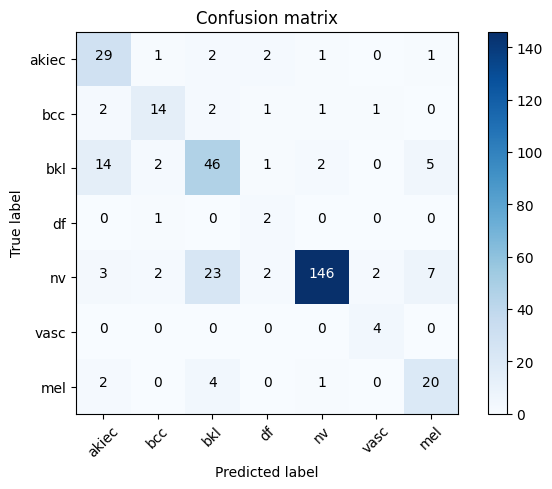

In [83]:
upper_body_accuracy = evaluate_body_region(upper_body_test_loader, "Upper body")




Mid body classification report:
              precision    recall  f1-score   support

       akiec       0.26      0.56      0.36         9
         bcc       0.77      0.82      0.79        28
         bkl       0.45      0.67      0.54        51
          df       0.09      1.00      0.17         1
          nv       0.98      0.89      0.93       875
        vasc       0.84      1.00      0.91        16
         mel       0.34      0.62      0.44        32

    accuracy                           0.87      1012
   macro avg       0.53      0.79      0.59      1012
weighted avg       0.92      0.87      0.89      1012



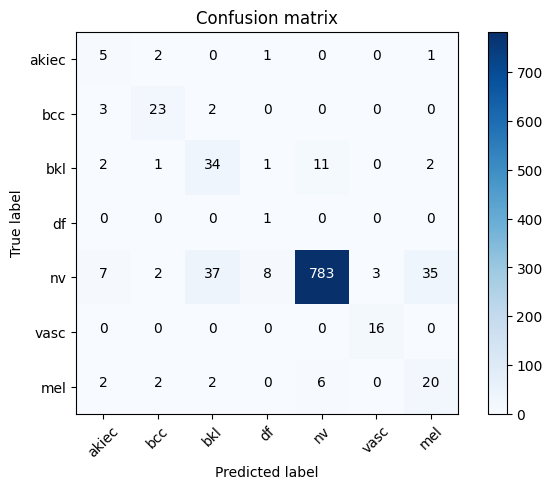

In [84]:
mid_body_accuracy = evaluate_body_region(mid_body_test_loader, "Mid body")

Lower body classification report:
              precision    recall  f1-score   support

       akiec       0.50      0.83      0.62         6
         bcc       0.80      0.73      0.76        11
         bkl       0.68      0.71      0.69        24
          df       0.57      1.00      0.73         8
          nv       0.99      0.95      0.97       439
        vasc       0.33      0.50      0.40         2
         mel       0.61      0.85      0.71        13

    accuracy                           0.93       503
   macro avg       0.64      0.80      0.70       503
weighted avg       0.95      0.93      0.94       503



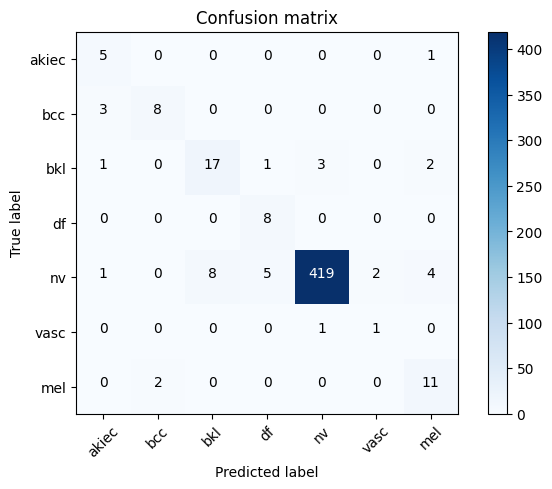

In [85]:
lower_body_accuracy = evaluate_body_region(lower_body_test_loader, "Lower body")

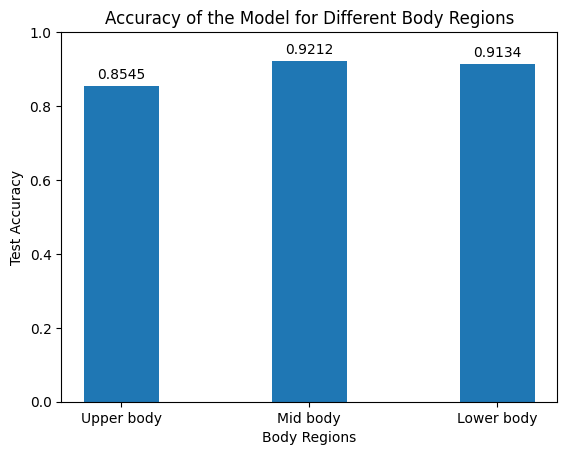

In [90]:

# Plot the bar chart with the accuracy values for each body region
body_regions = ["Upper body", "Mid body", "Lower body"]
fig, ax = plt.subplots()
bars = ax.bar(body_regions, accuracies, width=0.4)

plt.xlabel("Body Regions")
plt.ylabel("Test Accuracy")
plt.title("Accuracy of the Model for Different Body Regions")
plt.ylim(0, 1)

# Function to add the accuracy values on top of the bars
def add_values_on_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function to add the accuracy values on top of the bars
add_values_on_bars(bars)

# Display the plot
plt.show()
